In [1]:
import os
import fnmatch
import itertools
from datetime import datetime
from pathlib import Path

import geowombat as gw
# from tsplanet import download_data

import geopandas as gpd
import numpy as np
import sklearn_crfsuite
from affine import Affine
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Functions

In [13]:
def str_to_int(row):
    str_values = row['class'].split(',')
    return ','.join([str(str_to_int_dict[sv]) for sv in str_values])

In [20]:
def label_decoder(label):
    return int_to_str_dict[label]


def get_sample_xy(sample):
    return dict(zip(band_names, np.float64(sample[band_names].values))), label_decoder(int(sample.poly))


def get_array_xy(sample):
    return dict(zip(band_names, sample))

    
def samples_to_features(dfs):
    
    """
    sample = [[{t1}, {t2}, ..., {tn}], ..., [...]]
    """
    
    return [list(zip(*df.apply(get_sample_xy, axis=1))) for df in dfs]


def array_to_dict(*args):
    return [dict(zip(band_names, sample)) for sample in args]

## Download PlanetScope data

In [2]:
# download_data('/scratch/rsc4/graesser/temp/planet',
#               '/export/home/graesserj/code/python/github/planet/tsplanet/geojson/qld.geojson',
#               '2019-08-01', 
#               '2019-08-10',
#               cloud_cover=0.8,
#               api_key='des')

## Extract samples from training AOIs

In [3]:
# planet_dir = Path('/scratch/rsc4/graesser/temp/planet')
vector_dir = Path('/media/jcgr/data/imagery/google/training')
image_dir = Path('/media/jcgr/data/imagery/google/p225r083/brdf')

In [4]:
# filenames = ['20190802_234446_0f31_3B_AnalyticMS_SR',
#              '20190804_234646_100a_3B_AnalyticMS_SR', 
#              '20190809_234600_104a_3B_AnalyticMS_SR',
#              '20190809_234852_0f2a_3B_AnalyticMS_SR',
#              '20190812_234445_1005_3B_AnalyticMS_SR']

# filenames = ['20180111_131258_1024_3B_AnalyticMS_SR.tif', 
#              '20180111_131300_1024_3B_AnalyticMS_SR.tif', 
#              '20180117_131442_0e0e_3B_AnalyticMS_SR.tif',
#              '20180129_131341_1030_3B_AnalyticMS_SR.tif',
#              '20180129_131340_1030_3B_AnalyticMS_SR.tif',
#              '20180413_131755_1038_3B_AnalyticMS_SR.tif',
#              '20180413_131754_1038_3B_AnalyticMS_SR.tif',
#              '20180419_144202_1053_3B_AnalyticMS_SR.tif']

filenames = fnmatch.filter(os.listdir(image_dir.as_posix()), '*.tif')

filename_dict = dict()
for fn in filenames:
    filename_dict[fn.split('_')[3]] = fn

In [5]:
sorted_names = list(zip(*sorted(filename_dict.items())))

In [6]:
filenames = list(sorted_names[1])

In [7]:
time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]

In [8]:
rasters = [image_dir.joinpath(fn).as_posix() for fn in filenames]
vector = vector_dir.joinpath('p225r83.shp').as_posix()

In [9]:
#time_names = [datetime.strptime(Path(fn).name.split('_')[0], '%Y%m%d') for fn in filenames]

In [10]:
# rasters = [planet_dir.joinpath('raster').joinpath(fn).as_posix() for fn in filenames]
# vector = planet_dir.joinpath('cloud_training/training01.shp').as_posix()

### Plot the intersection

In [11]:
# with gw.config.update(ref_image=rasters[0], 
#                       ref_res=(10, 10), 
#                       sensor='planetscope'):
    
#     with gw.open(rasters,
#                  time_names=time_names,
#                  how='intersection',
#                  chunks=512) as ds:
        
#         dss = ds.mean(dim='time')
#         dss.attrs = ds.attrs
#         print(ds)
        
#         #dss.gw.imshow(band_names=['red', 'green', 'blue'], nodata=0, robust=True)

### Extract samples

#### Split samples

In [80]:
str_to_int_dict = dict(n=0, a=1, g=2, t=3, u=4, b=5, w=6, c=7, s=8, h=9)
int_to_str_dict = dict()
for k, v in str_to_int_dict.items():
    int_to_str_dict[v] = k

In [81]:
df = gpd.read_file(vector)

df['class_len'] = df['class'].str.len()
df['int_class'] = df.apply(str_to_int, axis=1)
out = df['int_class'].str.split(',', expand=True)

df_list = list()

for s in range(0, out.shape[1]):
    df_ = df.copy()
    df_['id'] = out.iloc[:, s]
    df_list.append(df_)

In [82]:
df_list[1].head()

,id,class,geometry,class_len,int_class
0,7,"c,c,c,c,c,c,a,s,c,c,h,a,a,a,a,a","POLYGON ((307838.814 -3622477.261, 307832.864 ...",31,"7,7,7,7,7,7,1,8,7,7,9,1,1,1,1,1"
1,7,"c,c,c,c,c,c,u,c,c,c,u,u,u,u,u,u","POLYGON ((323004.578 -3618411.783, 323004.578 ...",31,"7,7,7,7,7,7,4,7,7,7,4,4,4,4,4,4"
2,7,"c,c,c,c,c,c,w,w,h,w,c,c,w,c,c,w","POLYGON ((369694.535 -3678582.378, 369694.535 ...",31,"7,7,7,7,7,7,6,6,9,6,7,7,6,7,7,6"
3,7,"c,c,c,c,c,c,a,s,c,c,a,c,a,a,a,s","POLYGON ((364097.406 -3605700.986, 364097.406 ...",31,"7,7,7,7,7,7,1,8,7,7,1,7,1,1,1,8"
4,0,"n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n","POLYGON ((288664.936 -3610284.305, 288664.936 ...",31,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"


In [83]:
dfs = list()

with gw.config.update(sensor='bgrn'):

    with gw.open(rasters[0]) as ds:
        transform = ds.transform

    with gw.open(rasters, time_names=time_names) as ds:    

        transform = (ds.res[0], 0.0, ds.x.values[0], 0.0, -ds.res[1], ds.y.values[0])

        for ti, time in enumerate(ds.time.values):

            dss = ds.sel(time=time)
            dss.attrs = ds.attrs
            dss.attrs['transform'] = transform

            dfs.append(dss.gw.extract(df_list[ti]))

100%|██████████| 8/8 [00:00<00:00, 167.11it/s]


In [84]:
dfs[0].shape

(1292, 7)

## Convert samples to CRF features

In [85]:
band_names = ['blue', 'green', 'red', 'nir']
label_name = 'poly'

In [86]:
results = samples_to_features(dfs)

### CRF X and y

In [87]:
X = np.array(list(zip(*results))[0]).T.tolist()
print(len(X))

1292


In [88]:
y = np.array(list(zip(*results))[1]).T.tolist()
print(len(y))

1292


### Fit the CRF model

In [91]:
model = sklearn_crfsuite.CRF(algorithm='lbfgs', # Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
            c1=0.01,
            c2=0.01,
            max_iterations=1000,
            num_memories=10,
            period=10,
            epsilon=1e-06,
            delta=1e-06,
            linesearch='StrongBacktracking',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
            max_linesearch=20,
            all_possible_states=True,
            all_possible_transitions=True,
            verbose=False)

In [92]:
model.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=True, all_possible_transitions=True,
    averaging=None, c=None, c1=0.01, c2=0.01, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=1e-06, epsilon=1e-06, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch='StrongBacktracking',
    max_iterations=1000, max_linesearch=20, min_freq=None, model_filename=None,
    num_memories=10, pa_type=None, period=10, trainer_cls=None, variance=None,
    verbose=False)

In [147]:
# model.predict_marginals(X)[0]

In [148]:
# samples x time x n classes
# pred = np.array([[[ps['land'], ps['cloud']] for ps in p] for p in model.predict_marginals(X)], dtype='float64')

In [149]:
# pred.shape

### Open the data to predict on 

In [94]:
with gw.config.update(sensor='rgbn'):
    
    with gw.open(rasters[0]) as ds:
        #print(ds.data.max().compute())
        transform = ds.transform
    
    with gw.open(rasters, time_names=time_names) as ds:
        
        ds.attrs['transform'] = transform
        
        dss = ds[:, :, 1000:1512, 3000:3512].chunk((1, 256, 256)).fillna(0)
        #dss = gw.subset(ds, left=315416.003, top=-3611632.029, rows=500, cols=500).chunk((1, 1, 64, 64))
        #print(dss)
        #print(dss.data.max().compute())
        test = dss.astype('float64').data.compute()

In [95]:
test.shape

(16, 4, 512, 512)

In [96]:
test.max()

0.5157613948303316

In [97]:
ntime, nbands, nrows, ncols = test.shape

### Convert the array to CRF-compatible features

In [61]:
# array_to_dict(test[0].transpose(1, 2, 0).reshape(nrows*ncols, nbands)[0],
#               test[1].transpose(1, 2, 0).reshape(nrows*ncols, nbands)[0])

In [98]:
features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in test]
features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

### Predict on all time steps

In [99]:
# samples x time x n classes
pred = np.array([[[ps['n'], ps['a'], ps['g'], ps['t'], ps['u'], ps['w'], ps['c']+ps['h'], ps['s']] for ps in p] 
                 for p in model.predict_marginals(features)], dtype='float64')

In [100]:
pred.shape

(262144, 16, 8)

In [101]:
pred = pred.transpose(1, 2, 0).reshape(ntime, pred.shape[2], nrows, ncols)

In [102]:
pred.shape

(16, 8, 512, 512)

## Plot cloud probabilities

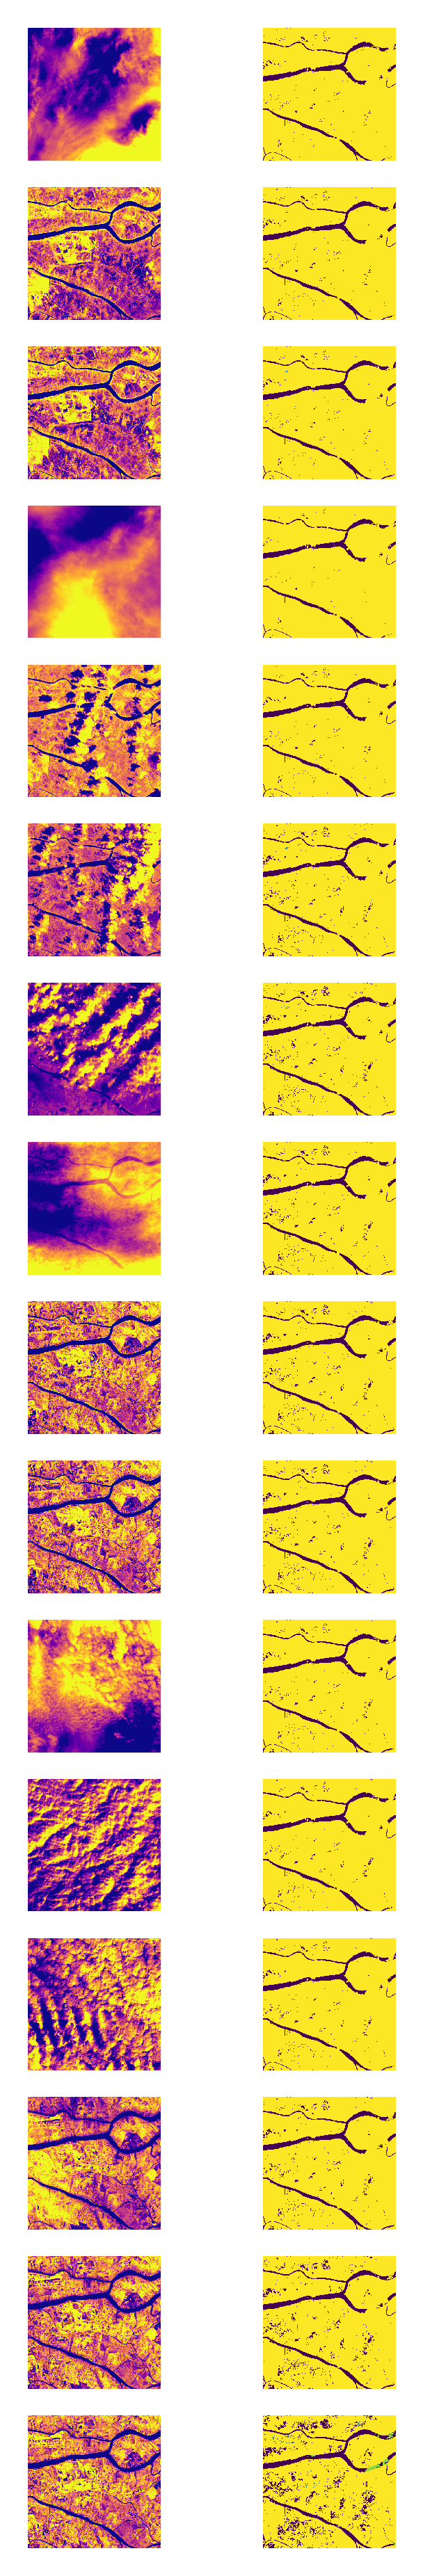

In [104]:
%matplotlib inline

fig, axes = plt.subplots(pred.shape[0], 2, dpi=400, figsize=(2, 12))

bidx = 3 # band index
cidx = 6 # class index

for pi in range(0, pred.shape[0]):

    ip = test[pi, bidx, :, :]
    ip[ip == 0] = np.nan
    
    axes[pi][0].imshow(ip, vmin=np.nanpercentile(ip, 10), vmax=np.nanpercentile(ip, 90), cmap='plasma')
    #axes[pi][1].imshow(pred[pi, cidx, :, :], vmin=0, vmax=1, cmap='plasma')
    axes[pi][1].imshow(pred[pi, :, :, :].argmax(axis=0))
    
#     axes[pi][0].set_xlabel('Time {:d}'.format(pi+1))
    
    axes[pi][0].axis('off')
    axes[pi][1].axis('off')

plt.show()

### Shape testing

In [ ]:
# a = np.arange(8*3*2).reshape(8,3,2)

In [ ]:
# time 1
# a[:, 0, :]

In [ ]:
# time 2
# a[:, 1, :]

In [ ]:
# a.transpose(1, 2, 0).reshape(3, 2, 2, 4)[1]